# Udacity Deep Reinforcement Learning Project 1: Navigation 
## *Learning to Navigate through a Banana-Rich Environment*

### **Project Description**
[//]: # (Image References)

[image1]: https://user-images.githubusercontent.com/10624937/42135619-d90f2f28-7d12-11e8-8823-82b970a54d7e.gif "Trained Agent"

A reinforcement learning agent will be trained to navigate on a 2D surface by choosing in which direction to travel given 37 dimensions of information about its environment at each time step, such as its location, momentum, and the distance from it to the bananas and walls in its "view". The agent must respond to each state with one of these four actions:

- **`0`** - move forward.
- **`1`** - move backward.
- **`2`** - turn left.
- **`3`** - turn right.

Visual representation of the state space from the agent's point of view:

![Trained Agent][image1]

The goal of training is for the agent to develop a policy of actions maximizing the agent's collisions with yellow bananas while minimizing its collisions with blue bananas. Therefore at each step the agent recieves one of three awards according to the outcome of the agent's previous choice of action:
-  **` 0`**  - no collision, or collision with wall
-  **`+1`** - successfully running over a yellow banana
-  **`-1`** - any contact with a blue banana

Episodes end only after a pre-specified number of steps (with the default apparently set to a maximum of 300 steps by the environment). An episode's final score is the unweighted sum of its rewards after each step.

The agent will use Deep Q-Learning techniques to asymptotically approximate the optimal policy for collecting as many yellow bananas as possible while avoiding blue bananas over the preset number of steps for each episode.  

The training benchmark specified in the [project rubric](https://review.udacity.com/#!/rubrics/3641/view) is to achieve an average score of at least 13 (over 100 consecutive episodes) over only 1800 training episodes or less.


#### **References and Resources**

- Background and design of Deep Q-Learning models and training methodologies covered in the [Course Textbook](http://go.udacity.com/rl-textbook) Chapter 6 Section 5.
- DQN algorithms used in the project developed from [this paper in *Nature*](https://www.nature.com/articles/nature14236) 
 - Mnih, V., Kavukcuoglu, K., Silver, D. *et al.* Human-level control through deep reinforcement learning. *Nature* **518**, 529–533 (2015). https://doi.org/10.1038/nature14236

- [Unity Machine Learning Agents](https://blogs.unity3d.com/2017/09/19/introducing-unity-machine-learning-agents/) Environment Resource

**Course code:**
- Copied to project folder directly from [DQN solution folder](https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/) and used here as-is:
 - dqn_agent.py
 - model.py
- Some modifications (discussed below) were made to the training function in the solution notebook dqn.ipynb, some cells from which have been copied into this Report notebook

**Saved weights** of agents trained to benchmark or better performance: 
- 'benchmark_weights.pth'
- 'trained_weights.pth'




## Environment Initialization

### **Only if necessary**

Unzip, Import and Install to set up Local Environment Files


**Note: Running the following two cells is probably not necessary!**


For safety, you must set  ``` necessary = TRUE ``` to run them.



In [1]:
import zipfile
import os

necessary = False
if necessary:
    with zipfile.ZipFile("unity_python.zip") as zip_ref:
        zip_ref.extractall()
    !pip -q install ./python   #./unity_python
    from unityagents import UnityEnvironment
    
    with zipfile.ZipFile('Banana_Linux.zip') as zip_ref:
        zip_ref.extractall()
    !chmod -R 755 Banana_Linux
    env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

### Initialize the UnityAgents Banana-World Environment

In [2]:
import numpy as np
!pip -q install ./python
from unityagents import UnityEnvironment

# change file_name if necessary:
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
### UnityAgent Environment Variables

# Load the banana brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print(brain)

# Reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Agent Information
print("Agents: ", len(env_info.agents))

# Action Space
action_size = brain.vector_action_space_size
print("Actions: ", action_size)

# State Space 
state = env_info.vector_observations[0]            # get the current state
state_size = len(state)
print("State size: ", state_size)

# State observation and Unity environment syntax
score = 0                                          # initialize the score
action = np.random.randint(action_size)            # select a (random) action
env_info = env.step(action)[brain_name]            # send the action to the environment
next_state = env_info.vector_observations[0]       # get the next state
reward = env_info.rewards[0]                       # get the reward
done = env_info.local_done[0]                      # see if episode has finished

print("\nAction: {}\nNext State:\n{}\nReward: {}\nDone: {}".format(action, next_state, reward, done))  

BananaBrain
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Agents:  1
Actions:  4
State size:  37

Action: 0
Next State:
[ 1.          0.          0.          0.          0.84173167  0.          0.
  1.          0.          0.06433759  0.          1.          0.          0.
  0.2517986   1.          0.          0.          0.          0.72478515
  0.          1.          0.          0.          0.2527748   0.          0.
  1.          0.          0.08042004  0.          1.          0.          0.
  0.31255436  0.          7.81049442]
Reward: 0.0
Done: False


## Project Design


In [4]:
from dqn_agent import Agent

### Agent Network Hyperparameters (defaults are set in dqn_agent.py)

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor used by Mnih et al. (2015)
TAU = 1e-3              # for (very!) 'soft update' of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 8        # how often to update the network, originally 4 (why?)

MAX_T = 301             # Max steps per episode; environment default is 300
fc_units = 64           # 32 in the model described in Mnih et al. (2015)

### Deep Q-Network training function:
**dqn**(*agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.1, eps_step=0.001*)

Some of the *slight* modifications to the code as provided in the [Deep Q-Network Solution notebook](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution):
- most importantly: small changes in syntax for interaction with the UnityAgent environment
- epsilon now decreases *linearly* at default rate of 0.001/episode; epsilon decayed exponentially in original (inspired by Mnih *et al.* (2015)
- the Agent model to trained must be provided to dqn(); to make it easier to work with different models


In [5]:
#@title Function **dqn**(*agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.1, eps_step=0.001*)
### This dqn algorithm is slightly modified from the one provided
### in the solution folder for the DQN coding exercise.
### The difference is mostly the change in syntax for interacting 
### with the UnityAgents environment, as provided by the course
### in the [Deep Q Network solution notebook][https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution]

from collections import deque
import torch

def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.1, eps_step=1e-3):
    """The Deep Q-Learning algorithm from the DQN solution folder, with some minor changes:
           - small changes in syntax for interaction with UA environment
           - epsilon decays **linearly**
           - the Agent model being trained must be explicitly specified  
    Params
    ======
        agent (object): name of agent to train
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode (env default max: 300)
        eps_start (float): starting value of epsilon for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_step (float): *linear* factor decreasing epsilon after each episode
    """
    
    scores = []                        # list containing scores from each episode
    window_size = 100                  # number of scores to rolling-remember
    scores_window = deque(maxlen=window_size)
    eps = eps_start                    # initialize epsilon
    dones = 0                          # count dones to see if there are any
    SOLVED = False                     # training will continue past benchmark
    
    for i_episode in range(1, n_episodes+1):

        #### vvv Changes made here vvv
        #### UnityAgents Environment syntax:
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # reset score
        for t in range(max_t):
            action = agent.act(state, eps)                 # epsilon-greedy action choice
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
        #### ^^^ End of syntax changes^^^

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                ### Question: are there ever any dones?
                dones += 1
                break 
        
        scores_window.append(score)       # save episode score for averaging
        scores.append(score)              # save episode score
        eps = max(eps_end, eps-eps_step)  # decrease epsilon LINEARLY to minimum of eps_end
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.3f}'.format(i_episode, np.mean(scores_window), eps))
        
        if np.mean(scores_window)>=13.0 and not SOLVED:
            print('\nEnvironment solved in {:d} episodes!'.format(i_episode))
            torch.save(agent.qnetwork_local.state_dict(), 'benchmark_weights.pth')
            #break
            ### continue training...
            SOLVED = True
            
    ### Final small cosmetic change made here:
    print('\r\nTotal Episodes {}\tFinal Average Score: {:.2f}'.format(n_episodes, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'trained_weights.pth')    
    print("Dones: ", dones)
    
    return scores

## Training

In [6]:
# Initialize an agent

agent = Agent(state_size, action_size, seed=10)

# Run DQN Training
scores = dqn(agent, n_episodes=2000, max_t=500, 
             eps_start=1.0, eps_end=0.001, eps_step=0.001)

Episode 100	Average Score: 0.12	Epsilon: 0.900
Episode 200	Average Score: 0.51	Epsilon: 0.800
Episode 300	Average Score: 1.84	Epsilon: 0.700
Episode 400	Average Score: 3.26	Epsilon: 0.600
Episode 500	Average Score: 4.69	Epsilon: 0.500
Episode 600	Average Score: 6.37	Epsilon: 0.400
Episode 700	Average Score: 7.70	Epsilon: 0.300
Episode 800	Average Score: 10.21	Epsilon: 0.200
Episode 900	Average Score: 12.38	Epsilon: 0.100
Episode 924	Average Score: 13.00
Environment solved in 924 episodes!
Episode 1000	Average Score: 13.64	Epsilon: 0.001
Episode 1100	Average Score: 13.53	Epsilon: 0.001
Episode 1200	Average Score: 15.02	Epsilon: 0.001
Episode 1300	Average Score: 15.81	Epsilon: 0.001
Episode 1400	Average Score: 15.48	Epsilon: 0.001
Episode 1500	Average Score: 16.31	Epsilon: 0.001
Episode 1600	Average Score: 16.36	Epsilon: 0.001
Episode 1700	Average Score: 15.61	Epsilon: 0.001
Episode 1800	Average Score: 16.14	Epsilon: 0.001
Episode 1900	Average Score: 15.39	Epsilon: 0.001
Episode 2000	Ave

## Results

**Average score reached benchmark of 13+ in 924 episodes.**

**Final average score after 2000 training episodes was 15+.**

In [12]:
### Calculate average scores over past 100 episodes
mean_scores = []
for i in np.arange(1,len(scores)):
    if i < 100:
        mean_score = np.mean(scores[:i])
    else:
        mean_score = np.mean(scores[i-100:i])       
    mean_scores.append(mean_score)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

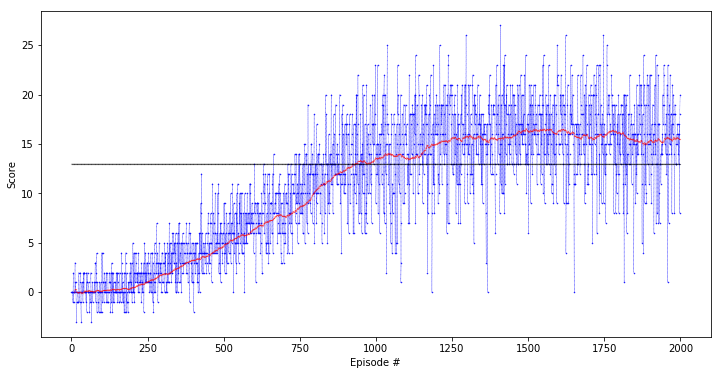

In [14]:
### Display results
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

### plot episode scores in blue:
plt.plot(np.arange(len(scores)), scores, 'bo--', linewidth=0.25, markersize=0.5,)

### plot running average in red:
plt.plot(np.arange(10, len(mean_scores)), mean_scores[10:], 'ro-', linewidth=0.25, markersize=0.1,)

### plot benchmark line
plt.plot(np.arange(len(mean_scores)), np.ones((len(mean_scores)))*13, 'ko-', linewidth=0.1, markersize=0.1,)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Discussion
### Questions and Observations
- QNetworks
- Learn
- Step
- Loss
- Replay memory
- Agent Structre
- DQN Design and Mods w/ questions


## Further Study and Possible Improvements

A few **questions and comments**:

- UPDATE_EVERY does what?

```
###Agent Learn line 105
# Compute Q targets for current states 
# Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

#### Is the (1-dones) term there because predicted rewards
#### should always be 0 for terminal state...?
#### Are there ever any dones...?
```


- **priority replay**

- **from-pixels** challenge

In [11]:
#env.close()

## Appendix I: Additional Data for Future Consideration